# Convex Hull Algorithms Analysis
This notebook demonstrates the various algorithsm for finding the convex hull of a set of points in a 2D plane.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import time

# generate n random points to be tested with the implemented algorithms
def generate_random_points(n):
    return [(random.randint(0, 100), random.randint(0, 100)) for _ in range(n)]

points = generate_random_points(100) #generate 100 random points in 2d for plt sampling later
points3d = np.random.rand(80, 3) # generate 80 random points in 3D

# helping function of orientation for algorithms
def orientation(p, q, r):
    val = q[0] * r[1] - r[0] * q[1] - p[0] * r[1] + r[0] * p[1] + p[0] * q[1] - q[0] * p[1] # formula of det for three points (3x3 matrix, where first column is 1s)
    if val == 0:
        return 0
    return 1 if val > 0 else -1

In [ ]:
def incremental_convex_hull(points):
    if len(points) < 3:
        raise ValueError("At least 3 points are required.")
    points = sorted(points, key=lambda x: (x[0], x[1])) # sort them by det since it is requried by the algorithm
    hull = [points[0], points[1]]
    for i in range(2, len(points)):
        hull.append(points[i])
        while len(hull) > 2 and orientation(hull[-3], hull[-2], hull[-1]) != -1:    # if orientation is non - negative, meaning not clock wise (parallel or to left, throw off the middle element)
            hull.pop(-2)
    lower_hull = [points[-1], points[-2]]   # ommit the last element from each to avoid double counting, same procedure for lower_hull
    for i in range(len(points) - 3, -1, -1):
        lower_hull.append(points[i])
        while len(lower_hull) > 2 and orientation(lower_hull[-3], lower_hull[-2], lower_hull[-1]) != -1:
            lower_hull.pop(-2)
    return hull[:-1] + lower_hull[:-1] # ommit the last element from each to avoid double counting

def gift_wrapping_convex_hull(points):
    if len(points) < 3:
        raise ValueError("At least 3 points are required.")
    
    S = set(points)  # all points into one set
    r0 = min(points, key=lambda p: (p[0], p[1]))  # find the left-most point, if multiple find the one with the least y value (p[1])
    r = r0  # inits
    hull = [r]
    
    while True:
        u = None  # Reset u for each iteration
        for t in S:
            if t == r:  #no need to check r with r, we may skip it for all the other points into S
                continue
            
            # check the orientation of the points r, u, t
            if u is None or orientation(r, u, t) == -1 or (orientation(r, u, t) == 0 and (min(r[0], t[0]) <= u[0] <= max(r[0], t[0]) and min(r[1], t[1]) <= u[1] <= max(r[1], t[1]))): #if CW(r,u,t) or c,u,t collinear and u into the rt segment, update u
                u = t
        
        if u is None:  # if no valid point found for u, exit the loop (something went wrong) error handler, caus ei had some issues here
            print("Error: No valid point found for u.")
            break

        if u == r0: # if we've wrapped around to the initial point r0, we're done, breaking condition according thoery
            break

        hull.append(u) # add the new point u to the convex hull
        r = u  # Update the current point to the new point u

        S.discard(r)  # remove u from the set S safely, used discard instead of remove due to KeyError issue

    return hull

def merge_hulls(hull_left, hull_right):
    # find upper and lower tangents (its the opposite actually here due to sorting of 3-4 points done by incremental_convex_hull base case in divide & conquer function)
    def find_tangents():
        i = max(range(len(hull_left)), key=lambda k: hull_left[k][0])   #right most from left hull (A)
        j = min(range(len(hull_right)), key=lambda k: hull_right[k][0]) #left most from right hull (B)
        # upper  tangent (we check the  angles now to extract the least lowest  y  value pair)
        while True:
            updated = False
            if orientation(hull_left[i], hull_right[j], hull_right[(j - 1) % len(hull_right)]) == -1: #must be CW to update it with new j
                j = (j - 1) % len(hull_right)
                updated = True
            if orientation(hull_right[j], hull_left[i], hull_left[(i + 1) % len(hull_left)]) == 1: #must be CCW to update it with new i
                i = (i + 1) % len(hull_left)
                updated = True
            if not updated:
                break
        upper_tangent = (i, j)

        # Lower tangent (same procedure but we check the opposite angles now to extract the biggest upper y value pair )
        i = max(range(len(hull_left)), key=lambda k: hull_left[k][0]) #right most from left hull (A)
        j = min(range(len(hull_right)), key=lambda k: hull_right[k][0]) #left most from right hull (B) 
        while True:
            updated = False
            if orientation(hull_left[i], hull_right[j], hull_right[(j + 1) % len(hull_right)]) == 1: #must be CCW to update it with new j
                j = (j + 1) % len(hull_right)
                updated = True
            if orientation(hull_right[j], hull_left[i], hull_left[(i - 1) % len(hull_left)]) == -1: #must be CW to update it with new i
                i = (i - 1) % len(hull_left)
                updated = True
            if not updated:
                break
        lower_tangent = (i, j)
        return upper_tangent, lower_tangent

    upper, lower = find_tangents()
    merged_hull = []

    # add points from left hull now
    i = upper[0]
    while True:
        merged_hull.append(hull_left[i])
        if i == lower[0]:
            break
        i = (i + 1) % len(hull_left)

    # add points from right hull
    j = lower[1]
    while True:
        merged_hull.append(hull_right[j])
        if j == upper[1]:
            break
        j = (j + 1) % len(hull_right)

    return merged_hull

def divide_conquer_convex_hull(points):
    """
    Computes the convex hull of a set of points using the Divide and Conquer approach.
    Uses a brute-force method for n < 6.
    """
    if len(points) < 6:
        # Base case: Use incremental_convex_hull for fewer than 5 points
        return incremental_convex_hull(points)

    # Sort points by x-coordinate
    points = sorted(points)
    
    
    # Split points into two halves
    mid = len(points) // 2
    left = points[:mid]
    right = points[mid:]

    # Recursively compute the convex hulls for the left and right sets
    hull_left = divide_conquer_convex_hull(left)
    hull_right = divide_conquer_convex_hull(right)

    # Merge the two convex hulls
    return merge_hulls(hull_left, hull_right)

def quickhull(A, B, S):
    if not S:  # base case: if S is empty, return the segment [A, B], according to lesson's theory.
        return [A, B]

    def distance(point): # function to compute the distance of a point from the line AB that is defined by two points (A,B).
        return abs((B[1] - A[1]) * point[0] - (B[0] - A[0]) * point[1] + B[0] * A[1] - B[1] * A[0]) / ((B[1] - A[1]) ** 2 + (B[0] - A[0]) ** 2) ** 0.5
    
    G = sorted(S, key=distance, reverse=True)[0] # find the point G in S that is farthest from the line AB.

    def existRightOfLine(P, Q, R): # helper function if a point R is to the right of the directed line PQ, returns positive value (formula: det (PQ , PR) convex product - εξωτερικο γινόμενο).
        return (Q[0] - P[0]) * (R[1] - P[1]) - (Q[1] - P[1]) * (R[0] - P[0]) > 0

    # split the remaining points into M: points to the right of the line AG and N: points to the right of the line GB.
    M = [point for point in S if existRightOfLine(A, G, point)]  # points right of AG
    N = [point for point in S if existRightOfLine(G, B, point)]  # points right of GB

    # recursively find the hull points for the two segments [A,G] and [G,B] till they dont have any internal points.
    return quickhull(A, G, M)[:-1] + quickhull(G, B, N) # skip the last point in each recursive result to avoid duplicate points.

def quickhull_convex_hull(points):
    A = min(points, key=lambda p: p[0])  # leftmost point in dataset
    B = max(points, key=lambda p: p[0])  # rightmost point in datase

    S1 = [point for point in points if orientation(A, B, point) == 1] #CCW means above the line (its left side so include it in upper hull)
    S2 = [point for point in points if orientation(A, B, point) == -1] #CW means under the line (its right side so include it in lower hull)

    # recursively find upper hull (A to B) and lower hull (B to A) respectively.
    upper_hull = quickhull(A, B, S1)
    lower_hull = quickhull(B, A, S2)
    
    return upper_hull[:-1] + lower_hull[:-1] # combine the results from the upper and lower hulls, excluding last points as duplicate.



N          Algorithm            Time (s)  
----------------------------------------
10000      Incremental          0.058000  
10000      Gift Wrapping        0.049999  
10000      Divide & Conquer     0.037992  
10000      QuickHull            0.028005  
100000     Incremental          0.609400  
100000     Gift Wrapping        0.112998  
100000     Divide & Conquer     0.574999  
100000     QuickHull            0.632619  
1000000    Incremental          6.710535  
1000000    Gift Wrapping        0.342000  
1000000    Divide & Conquer     8.538469  
1000000    QuickHull            5.335534  


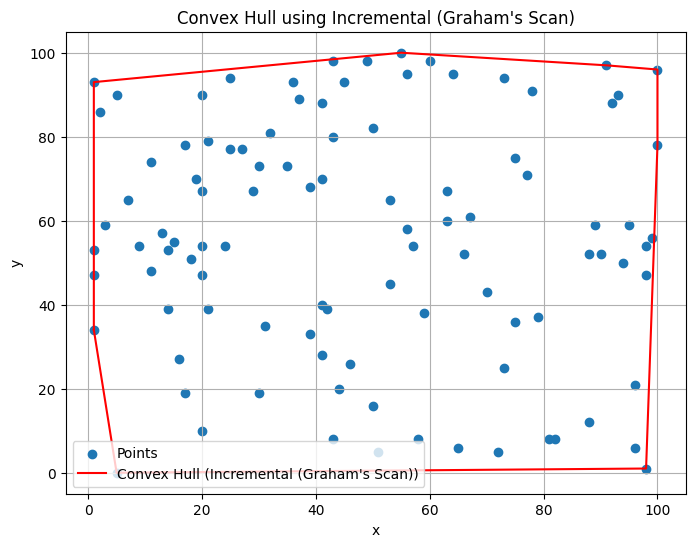

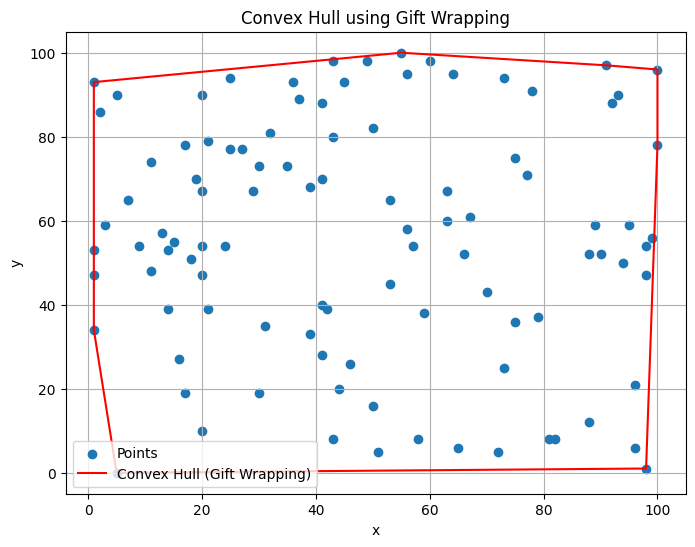

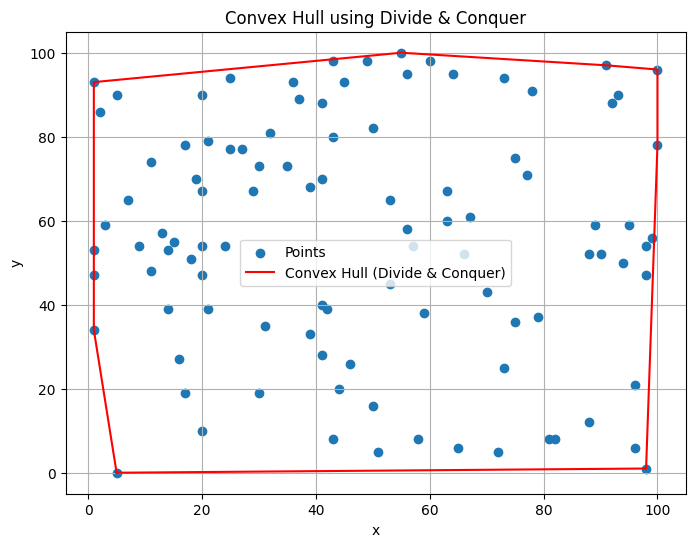

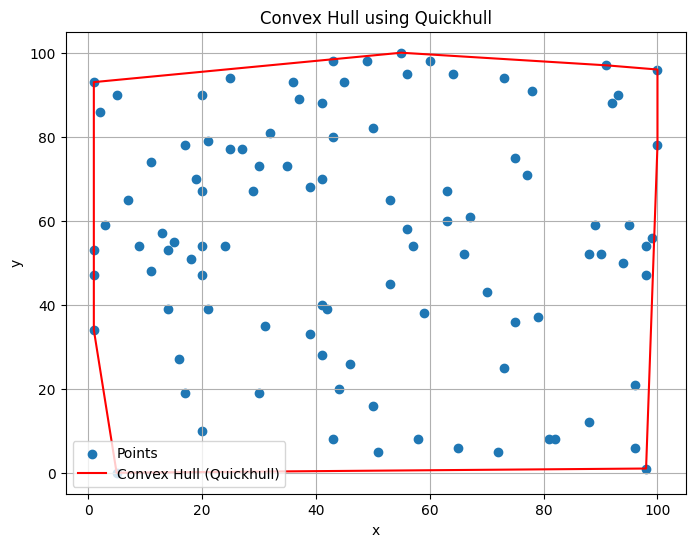

In [3]:
# ! runtime on local machine ~20 secs !
def plot_convex_hull(points, hull, algorithm_name):
    points_x, points_y = zip(*points)
    hull_x, hull_y = zip(*(hull + [hull[0]]))  # close the hull loop
    plt.figure(figsize=(8, 6))
    plt.scatter(points_x, points_y, label="Points")
    plt.plot(hull_x, hull_y, label=f"Convex Hull ({algorithm_name})", color='red')
    plt.legend()
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(f"Convex Hull using {algorithm_name}")
    plt.grid(True)
    
def benchmark():
    algorithms = [
        ("Incremental", incremental_convex_hull),
        ("Gift Wrapping", gift_wrapping_convex_hull),
        ("Divide & Conquer", divide_conquer_convex_hull),
        ("QuickHull", quickhull_convex_hull)
    ]
    point_sizes = [10000, 100000, 1000000]
    results = []

    for n in point_sizes:   # run each algorithm for each n
        for algo_name, algo_func in algorithms:
            points = generate_random_points(n)
            start_time = time.time()
            algo_func(points)
            elapsed_time = time.time() - start_time
            results.append([n, algo_name, round(elapsed_time, 6)])
    
    results.sort(key=lambda x: x[0]) # sort them first by n and then by algorithm name

    header = ["N", "Algorithm", "Time (s)"]  # display results in a table format
    print(f"{header[0]:<10} {header[1]:<20} {header[2]:<10}")
    print("-" * 40)
    for row in results:
        print(f"{row[0]:<10} {row[1]:<20} {row[2]:<10.6f}")
        
    return None
    
# for each algorithm, calculate the convex hull and then plot it (sample n=100)
hull = incremental_convex_hull(points) 
plot_convex_hull(points, hull, "Incremental (Graham's Scan)")

hull = gift_wrapping_convex_hull(points)
plot_convex_hull(points, hull, "Gift Wrapping")

hull = divide_conquer_convex_hull(points)
plot_convex_hull(points, hull, "Divide & Conquer")

hull = quickhull_convex_hull(points)
plot_convex_hull(points, hull, "Quickhull")

benchmark()

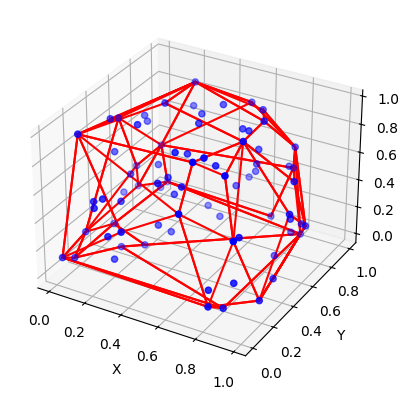

In [4]:
from scipy.spatial import ConvexHull

hull = ConvexHull(points3d) #!!!!!Note for instructors:  compute the convex hull (it uses the QuichHull algorithm as this is the default algorithm for the method 'ConvexHull')

# plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points3d[:, 0], points3d[:, 1], points3d[:, 2], color='blue')
for simplex in hull.simplices:
    ax.plot(points3d[simplex, 0], points3d[simplex, 1], points3d[simplex, 2], color='red')
ax.set_xlabel('X') # set labels for axes
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()


Optimal solution:
  x1 = 1.7204, x2 = 1.0968
Optimal value (maximizing 3x1 - 10x2) = -5.8065


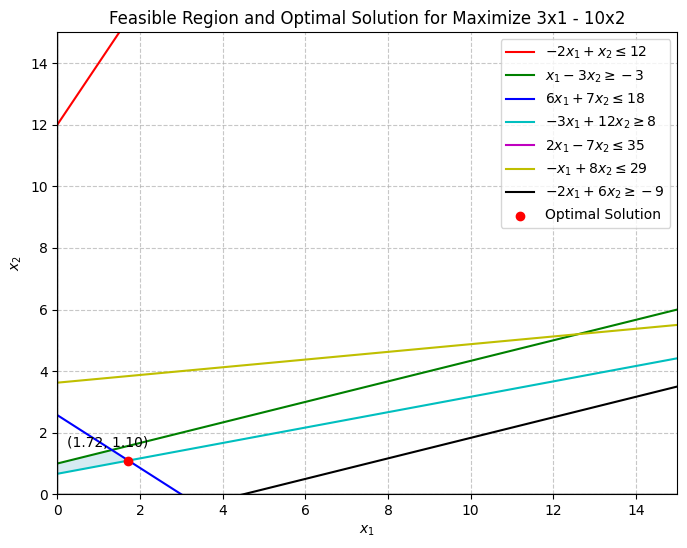

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linprog

#       define feasible region

x1_range = np.linspace(0, 15, 500) # grid range for plotting
x2_range = np.linspace(0, 15, 500)
X1, X2 = np.meshgrid(x1_range, x2_range)

constraint1 = (-2*X1 + X2 <= 12)    # original constraints (as given) on (X1, X2):
constraint2 = (X1 - 3*X2 >= -3)
constraint3 = (6*X1 + 7*X2 <= 18)
constraint4 = (-3*X1 + 12*X2 >= 8)
constraint5 = (2*X1 - 7*X2 <= 35)
constraint6 = (-X1 + 8*X2 <= 29)
constraint7 = (-2*X1 + 6*X2 >= -9)

feasible_region = (constraint1 & constraint2 & constraint3 & constraint4 & constraint5 & constraint6 & constraint7) # feasible region is the intersection of all constraints
feasible_numeric = feasible_region.astype(int) #  a numeric filter (0/1) array to mask out infeasible points
feasible_masked = np.ma.array(feasible_numeric, mask=~feasible_region)

#       solve LP problem

c = [-3, 10]     # we minimize the maximizing problem (f(x) = -3*x1 + 10*x2)
A_ub = [    # A array 2x7 of constraint for x1,x2 vars
    [-2,  1],
    [-1,  3],
    [ 6,  7],
    [ 3, -12],
    [ 2, -7],
    [-1,  8],
    [ 2, -6]
]
b_ub = [12, 3, 18, -8, 35, 29, 9] # B array 1x7 (solution values)
bounds = [(0, None), (0, None)] # x1, x2 >= 0.

res = linprog(c, A_ub=A_ub, b_ub=b_ub, bounds=bounds, method='highs') # solve given LP problem using linprog with highs method (minimizing -3*x1+10*x2)

if res.success:
    x_opt, y_opt = res.x    # find max optimal vale
    optimal_value = 3*x_opt - 10*y_opt
    print("Optimal solution:")
    print(f"  x1 = {x_opt:.4f}, x2 = {y_opt:.4f}")
    print(f"Optimal value (maximizing 3x1 - 10x2) = {optimal_value:.4f}")
else:
    print("No optimal solution found.")
    x_opt, y_opt = None, None

#       plotting 

plt.figure(figsize=(8, 6))  
plt.contourf(X1, X2, feasible_masked, levels=[0.5, 1.5], colors=['lightblue'], alpha=0.5)   # feasible area

x_line = np.linspace(0, 15, 300)    # constraints
plt.plot(x_line, (2*x_line + 12), 'r', label=r'$-2x_1+x_2\leq12$')
plt.plot(x_line, (x_line + 3) / 3, 'g', label=r'$x_1-3x_2\geq-3$')
plt.plot(x_line, (18 - 6*x_line) / 7, 'b', label=r'$6x_1+7x_2\leq18$')
plt.plot(x_line, (3*x_line + 8) / 12, 'c', label=r'$-3x_1+12x_2\geq8$')
plt.plot(x_line, (2*x_line - 35) / 7, 'm', label=r'$2x_1-7x_2\leq35$')
plt.plot(x_line, (x_line + 29) / 8, 'y', label=r'$-x_1+8x_2\leq29$')
plt.plot(x_line, (2*x_line - 9) / 6, 'k', label=r'$-2x_1+6x_2\geq-9$')

if x_opt is not None:   # optimal point 
    plt.scatter(x_opt, y_opt, color='red', zorder=5, label="Optimal Solution")
    plt.annotate(f"({x_opt:.2f}, {y_opt:.2f})",
                 (x_opt, y_opt), textcoords="offset points", xytext=(-15, 10), ha="center")

plt.xlim(0, 15) # setup
plt.ylim(0, 15)
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title("Feasible Region and Optimal Solution for Maximize 3x1 - 10x2")
plt.axhline(0, color='black', linewidth=1)
plt.axvline(0, color='black', linewidth=1)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()


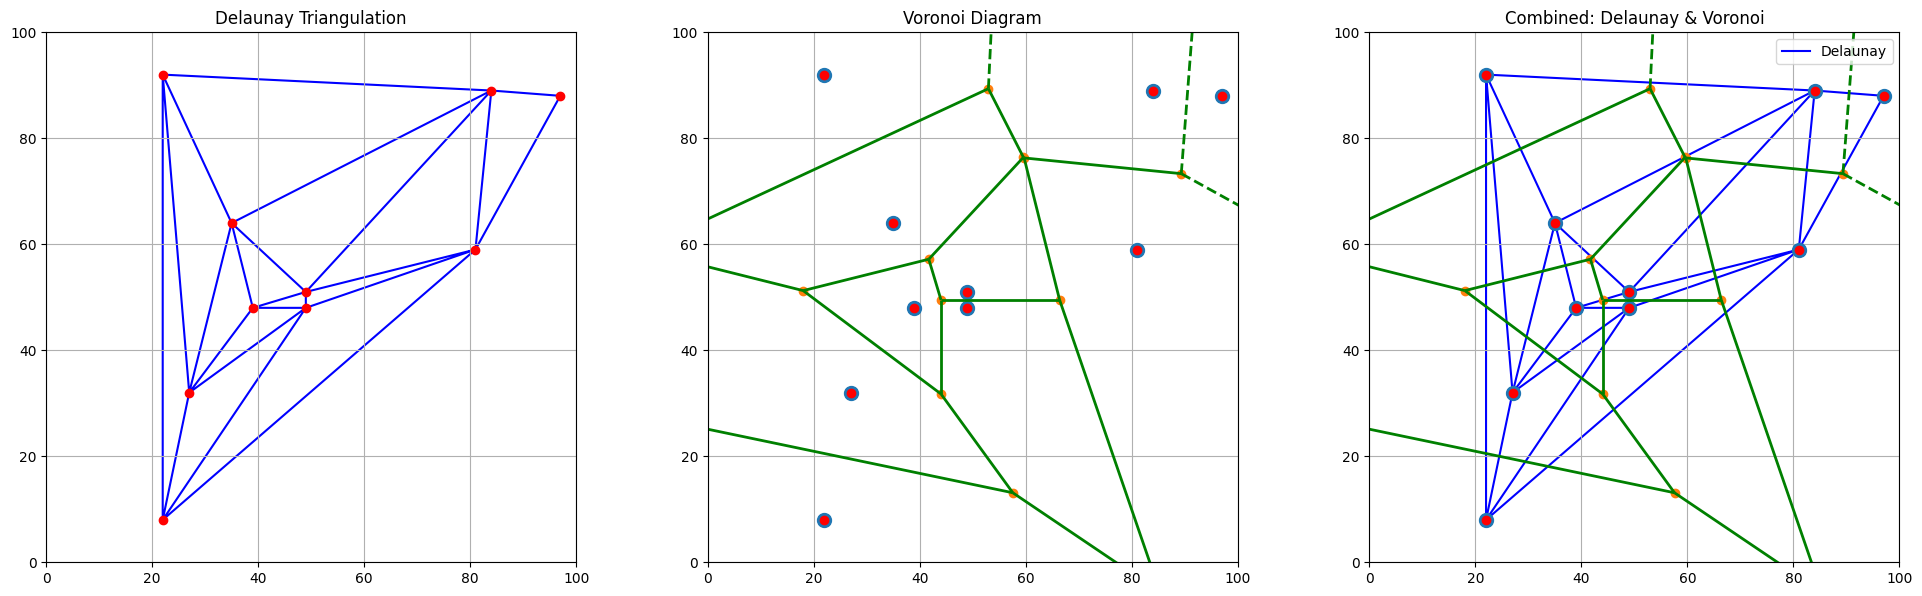

In [6]:
from scipy.spatial import Delaunay, Voronoi, voronoi_plot_2d # our helping functions to depict the triangulation and the diagram 

points = generate_random_points(10)  # in this exercise i used 15 instead of 100 points, for better visualization of the relationship that we want to prove (duality) (P is set with 15 points)
points_np = np.array(points) # convert them to np arr cause scipy lib cannot handle tuples
tri = Delaunay(points_np) # delaunay diagram
vor = Voronoi(points_np) # voroin diagram


# plotting to prove the connection between Delaunay and Voronoi (3 plots)
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

#  1:  Delaunay 
axs[0].triplot(points_np[:, 0], points_np[:, 1], tri.simplices, color='blue')
axs[0].plot(points_np[:, 0], points_np[:, 1], 'o', color='red')
axs[0].set_title('Delaunay Triangulation')
axs[0].set_xlim(0, 100)
axs[0].set_ylim(0, 100)
axs[0].set_aspect('equal')
axs[0].grid(True)

#  2: Voronoi (helping function found from spatial lib)
voronoi_plot_2d(vor, ax=axs[1], show_vertices=True, line_colors='green', line_width=2, point_size=20)
axs[1].plot(points_np[:, 0], points_np[:, 1], 'o', color='red')
axs[1].set_title('Voronoi Diagram')
axs[1].set_xlim(0, 100)
axs[1].set_ylim(0, 100)
axs[1].set_aspect('equal')
axs[1].grid(True)

# 3: Combined Delaunay & Voronoi to prove the duality that connects them
axs[2].triplot(points_np[:, 0], points_np[:, 1], tri.simplices, color='blue', label='Delaunay') # first, the trianngulation
voronoi_plot_2d(vor, ax=axs[2], show_vertices=True, line_colors='green', line_width=2, point_size=20) #then overlap it with Voronoi

axs[2].plot(points_np[:, 0], points_np[:, 1], 'o', color='red')
axs[2].set_title('Combined: Delaunay & Voronoi')
axs[2].set_xlim(0, 100)
axs[2].set_ylim(0, 100)
axs[2].set_aspect('equal')
axs[2].grid(True)
axs[2].legend()

plt.tight_layout()      # putted tight_layout cause i had problems with fitting them side by side all of the three plots
plt.show()


n = 1250: Delaunay time = 0.0080s, Voronoi time = 0.0130s
n = 2500: Delaunay time = 0.0150s, Voronoi time = 0.0170s
n = 5000: Delaunay time = 0.0390s, Voronoi time = 0.0570s
n = 10000: Delaunay time = 0.0730s, Voronoi time = 0.1837s
n = 20000: Delaunay time = 0.1863s, Voronoi time = 0.3380s
n = 40000: Delaunay time = 0.4470s, Voronoi time = 0.6480s
n = 80000: Delaunay time = 0.9851s, Voronoi time = 1.3860s
n = 160000: Delaunay time = 2.0381s, Voronoi time = 3.1389s
n = 320000: Delaunay time = 4.1038s, Voronoi time = 5.3139s
n = 640000: Delaunay time = 8.4811s, Voronoi time = 9.0250s


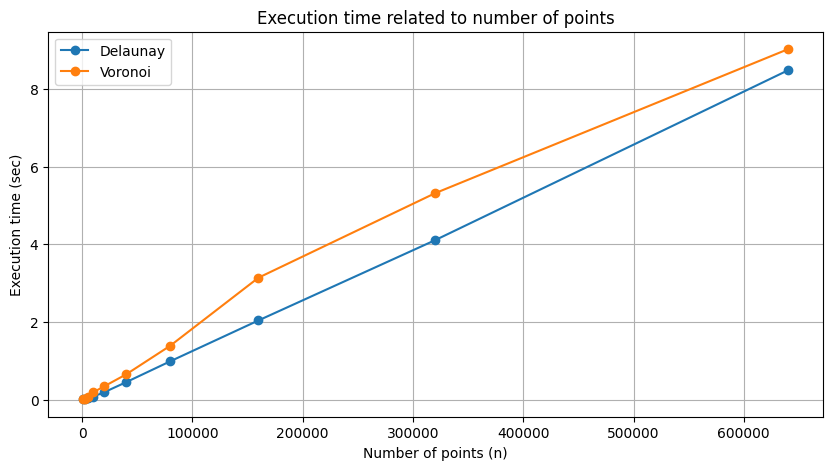

In [7]:
# ! runtime on local machine ~40 secs !
def generate_random_points_2(n):
    return [(random.randint(0, 1000), random.randint(0, 1000)) for _ in range(n)]

# Λίστα με διαφορετικά πλήθη σημείων για τις δοκιμές
n_values = [1250, 2500, 5000, 10000, 20000, 40000, 80000, 160000, 320000, 640000]
delaunay_times = []
voronoi_times = []

for n in n_values:
    pts = np.array(generate_random_points_2(n)) # creation of test points and numpy them
    
    start_time = time.time() # compute time of Delaunay
    tri = Delaunay(pts)
    end_time = time.time()
    dt_delaunay = end_time - start_time
    delaunay_times.append(dt_delaunay)
    
    
    start_time = time.time() # compute time of Voronoi
    vor = Voronoi(pts)
    end_time = time.time()
    dt_voronoi = end_time - start_time
    voronoi_times.append(dt_voronoi)
    
    print(f"n = {n}: Delaunay time = {dt_delaunay:.4f}s, Voronoi time = {dt_voronoi:.4f}s")

plt.figure(figsize=(10, 5)) # plotting to find complexity
plt.plot(n_values, delaunay_times, marker='o', label="Delaunay")
plt.plot(n_values, voronoi_times, marker='o', label="Voronoi")
plt.xlabel("Number of points (n)")
plt.ylabel("Execution time (sec)")
plt.title("Execution time related to number of points")
plt.legend()
plt.grid(True)
plt.show()

#after some tests that i did locally and from the saved screenshot image in the folder, the complexity seems to be log-linear (n * logn) and according to our lesson's note the complexity of the algorithms indeed is n*logn.